# ConvNet with Keras including Batchnorm, Dropout and Ensemling

Marek Zielinski, 21/08/2017

### TOC

- [1. Introduction](#introduction)
<br><br>
- [2. Data preparation and EDA](#data-preparation)
    - [2.1 Load data](#load-data)
    - [2.2 Reshape image matrices](#Reshape)
    - [2.3 Visualize data](#visualize-data)
    - [2.4 Label one-hot encoding](#label-one-hot-encoding)
    - [2.5 Split data into training and validation set](#split-train-test)
<br><br>
- [3. ConvNet model](#ConvNet-model)
    - [3.1 Model architecture](#model-architecture)
<br><br>
- [4. Prediction and evaluation](#evaluation)
    - [4.1 Data augmentation](#data-augmentation)
    - [4.2 Training and validation of a single model](#training-and-validation)
    - [4.3 Ensembling](#ensembling)
    - [4.4 Confusion matrix and classification report](#confusion-matrix)
    

## <a name="introduction"></a>1. Introduction

This is a simple model of Convolutional Network implementing Batchnorm and Dropout for digit recognition. The model and some improvements are inspired by Jeremy Howard’s fast.ai deep learning MOOC.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

np.random.seed(4321)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback
from keras.metrics import categorical_accuracy
import itertools
import time

import tensorflow as tf

Using TensorFlow backend.


In [2]:
version = "no-data-aug-007"

In [3]:
import dill as pickle

objects_path = "../objects/"

def pickle_dump(obj, filename):
    with open(objects_path + filename + '-v-' + version + '.pkl', 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [5]:
sns.set(style='dark', context='notebook', palette='GnBu_d')
sns_palette = sns.color_palette("GnBu_d",10)

## <a name="data-preparation"></a>2. Data preparation and EDA

### <a name="load-data"></a>2.1 Load data

In [6]:
#Load training and test data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
print(train.shape)
train.head(2)

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


We see that some pixels are always black, although neither the top row or bottom row is all black, thus there are some numbers that touch the edges of the image. This suggests to use ZeroPadding layer before each convolution layer so we will not loose any information.

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


Let's look at count for each of the numbers.

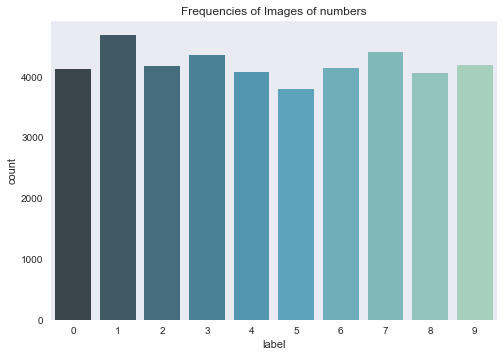

In [9]:
Y_data = train['label']
X_data = train.iloc[:,1:]


p = sns.countplot(Y_data,palette=sns_palette)
sns.plt.title("Frequencies of Images of numbers")
plt.show()

Training dataset apears to be balanced.

In [10]:
#del train

In the last step we define a function that will perform normalization from [0.255] to [0..1] to help the ConvNet converge faster. It will be used in the first lambda layer of the Keras model.

In [11]:
def normalize_input(x):
    return (x/255.0)

In [12]:
X_data = normalize_input(X_data)
test = normalize_input(test)

### <a name="Reshape"></a>2.2 Reshape image matrices

In [13]:
# Reshape image from 1D 784 to (28x28x1)
X_data_np = X_data.values.reshape(-1,28,28,1)
test_np = test.values.reshape(-1,28,28,1)

We need to reshape the images to 28x28x1 to add channel dimension that is required by Keras.

### <a name="visualize-data"></a>2.3 Visualize data

Let's look at a few random images and their labels.

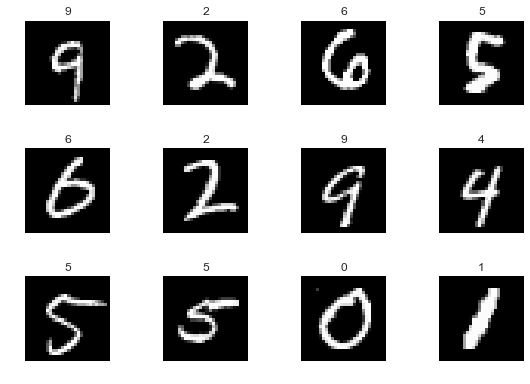

In [14]:
n_view = 12
ids = np.random.choice(range(0,len(X_data_np)),size=n_view,replace=False)
#X_vis = X_data_np[ids]
#Y_vis = Y_data.iloc[ids]
#X_vis = X_vis.reshape(-1,28,28)

plt.figure(figsize=(8, 5))
plt.subplots(3,4)
for i,id in enumerate(ids):
    plt.subplot(3,4, i+1)
    plt.imshow(X_data_np[id].reshape(28,28),cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title(Y_data.iloc[id])
    plt.tight_layout()
plt.show()

### <a name="label-one-hot-encoding"></a>2.4 Label one-hot encoding

We have 10 digits as labels from 0 to 9. We need to onvode these labels with one hot encoding.

In [15]:
Y_data_cat = to_categorical(Y_data, num_classes = 10)
Y_data_cat[0]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

### <a name="split-train-test"></a>2.5 Split data into training and validation set

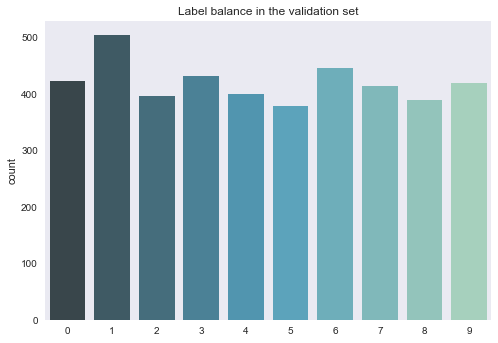

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X_data_np, Y_data_cat, test_size=0.1, random_state=4321)

p = sns.countplot(pd.DataFrame(Y_val).idxmax(1),palette=sns_palette)
sns.plt.title("Label balance in the validation set")
plt.show()

In [17]:
#Uncomment to use only a fraction of training data to speed up testing and we can use the whole validation set
#sample_frac = 0.25
#np.random.seed(4321)
#sample_ids = np.random.choice(range(len(X_train)),size=int(len(X_train) * sample_frac))
#X_train = X_train[sample_ids]
#Y_train = Y_train[sample_ids]

As we see above we have a similar distribution of levels in the validation set as in the whole sample. We won't have a problem with overrepresentation of some labels.

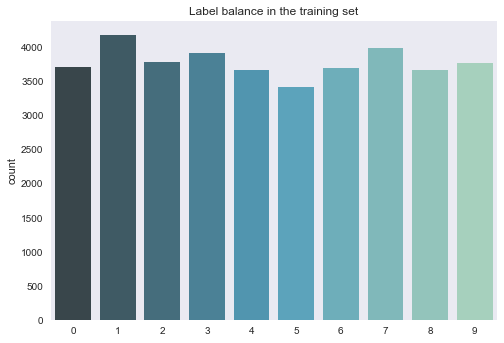

In [18]:
p = sns.countplot(pd.DataFrame(Y_train).idxmax(1),palette=sns_palette)
sns.plt.title("Label balance in the training set")
plt.show()

Let's check that everything is ok with the trainging data and labels

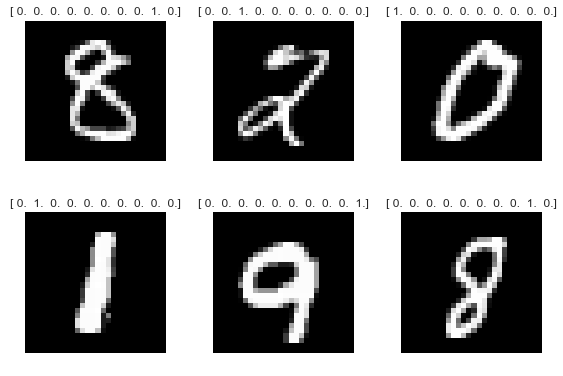

In [19]:
n_view = 6
ids = np.random.choice(range(0,len(X_train)),size=n_view,replace=False)
#X_vis = X_data_np[ids]
#Y_vis = Y_data.iloc[ids]
#X_vis = X_vis.reshape(-1,28,28)

plt.subplots(2,3)
for i,id in enumerate(ids):
    plt.subplot(2,3, i+1)
    plt.imshow(X_train[id].reshape(28,28),cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title(Y_train[id])
    plt.tight_layout()
plt.show()

## <a name="ConvNet-model"></a>3. ConvNet model

### <a name="model-architecture"></a>3.1 Model architecture

In [20]:
def cnn_model(dropouts = [0, 0.1, 0.1, 0, 0.25, 0.5]):
    """Builds and compiles Keras model for CNN with provided dropouts"""
    model = Sequential([
        Conv2D(32,(3,3), activation='relu' , input_shape=(28,28,1)),
        BatchNormalization(axis=1),
        Dropout(dropouts[0]),
        ZeroPadding2D(),
        Conv2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Dropout(dropouts[1]),
        ZeroPadding2D(),
        Conv2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Dropout(dropouts[2]),
        ZeroPadding2D(),
        Conv2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Dropout(dropouts[3]),
        Flatten(),
        BatchNormalization(),
        Dropout(dropouts[4]),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropouts[5]),
        Dense(10,activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
model = cnn_model()

In [22]:
pickle_dump(model.get_config(),'cnn-model-get_config-dump')

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        104       
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 32)        52        
__________

Now let's look at our ConvNet model as a graph.

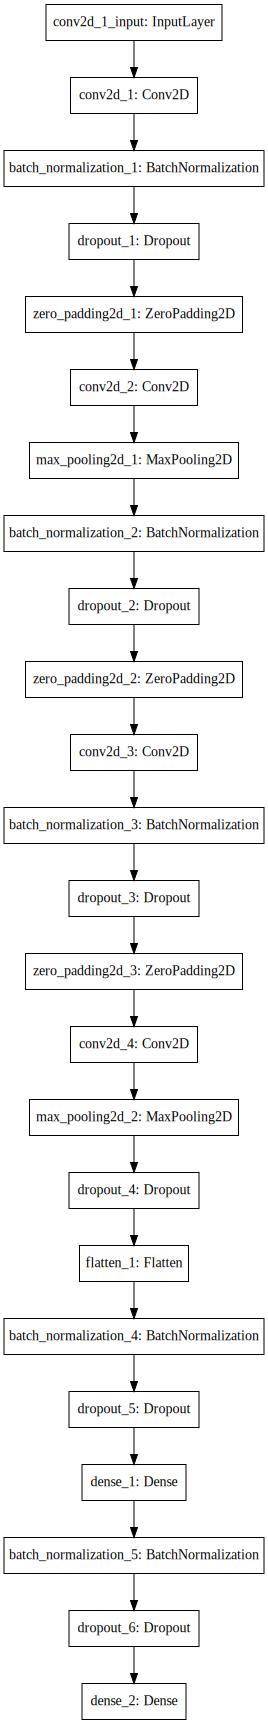

In [24]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model).create(prog='dot', format='svg'))

With Keras 2 it's better to set batch_size so it is a divisor of the number of samples. The new version requires steps per epoch instead of sample number so we either will have aditional repeated samples per epoch or less.

In [25]:
batch_size=400

## <a name="evaluation"></a>4. Prediction and evaluation

### <a name="data-augmentation"></a>4.1 Data augmentation

In [26]:
genAug = ImageDataGenerator(rotation_range=5, width_shift_range=0.05, shear_range=0.05,
                             height_shift_range=0.05, zoom_range=0.05)
gen = ImageDataGenerator()
batches = gen.flow(X_train, Y_train, batch_size=batch_size)
val_batches = gen.flow(X_val, Y_val, batch_size=batch_size)

batches_aug = genAug.flow(X_train, Y_train, batch_size=batch_size)
#val_batches_aug = genAug.flow(X_val, Y_val, batch_size=batch_size)


### <a name="training-and-validation"></a>4.2 Training and validation of a single model

The approach that we have chosen 
First we try a few epochs with default learning rate and no data augmentation. Most of the time it's the best approach. We try to do it without Augmentation first to make sure that the model does not get stuck on predicting the same class for every input.
After a few tries the most promising approach was to start training the model without data augmentation for a few epochs. Then we try to confuse the model with data augmentation and then again we train the model using the original training data.

In [27]:
def fit_model(model, epochs_per_each_step=4, epochs_last_step=2,
              steps=[4,4],
              use_train_batches = None,
              history_callback=None,
              model_save_callback=None,
              history=[], 
              callbacks=[],
              start_lr=None, lr_decrease_after_steps=1, min_lr=0.000001):
    """Runs model.fit_generator alternating non augemented and augmented data"""
    lr_changed = False
    model_save_callback.Reset()
    callbacks.append(model_save_callback)
    callbacks.append(history_callback)
    
    if (use_train_batches == None):
        use_train_batches = batches.n // batches.batch_size
    if (start_lr == None):
        print("Starting with default learning rate.")
    else:
        model.optimizer.lr = start_lr
        last_lr = start_lr
        print("Setting learning rate to: " + str(model.optimizer.lr))

    #print("No data augmentation - Initial Epoch on full training set")
    #model.fit_generator(batches, epochs=1, 
    #                    steps_per_epoch = batches.n // batches.batch_size,
    #                    #steps_per_epoch = 4,
    #                    validation_data=val_batches, 
    #                    validation_steps = val_batches.n // val_batches.batch_size, 
    #                    verbose=1,
    #                    callbacks=callbacks
    #                    )
    #history.extend(history_callback)
        
    for i in range(steps[0]):
        print("Fitting step: " + str(i+1))
        if ((i > 0) and (lr_changed)):
            print("Setting learning rate to: " + str(last_lr))
            lr_changed = False
            
        print("No data augmentation")
        model.fit_generator(batches, epochs=epochs_per_each_step, 
                            steps_per_epoch = use_train_batches,
                            validation_data=val_batches, 
                            validation_steps = val_batches.n // val_batches.batch_size, 
                            verbose=1,
                            callbacks=callbacks
                           )
        history.extend(history_callback)
        
        #First set the learning rate as high as possible
        if (i==0 and (start_lr == None)):
            model.optimizer.lr = 0.1
            last_lr = 0.1
            lr_changed = True
        elif ((i % lr_decrease_after_steps) == 0):
            #Then decrease the learning rate sysytematically
            last_lr = last_lr/10
            model.optimizer.lr = last_lr
            lr_changed = True
            if (last_lr < min_lr):
                model.optimizer.lr = min_lr 
                last_lr = min_lr
                print('Minimum learning rate limit reached.')
                lr_changed = False

    for i in range(steps[1]):
        print("Fitting step: " + str(steps[0] + i + 1))
        if ((i > 0) and (lr_changed)):
            print("Setting learning rate to: " + str(last_lr))
            lr_changed = False
            
        print("Add data augmentation")
        model.fit_generator(batches_aug, epochs=epochs_per_each_step, 
                            steps_per_epoch = use_train_batches,
                            validation_data=val_batches, 
                            validation_steps = val_batches.n // val_batches.batch_size, 
                            verbose=1,
                            callbacks=callbacks
                           )
        history.extend(history_callback)
        
        if ((i % lr_decrease_after_steps) == 0):
            #Then decrease the learning rate sysytematically
            last_lr = last_lr/10
            model.optimizer.lr = last_lr
            lr_changed = True
            if (last_lr < min_lr):
                model.optimizer.lr = min_lr 
                last_lr = min_lr
                print('Minimum learning rate limit reached.')
                lr_changed = False
                
    print("No data augmentation - Last step")
    print("Setting learning rate to: " + str(last_lr))
    model.fit_generator(batches, epochs=epochs_last_step, 
                            steps_per_epoch = use_train_batches,
                            validation_data=val_batches, 
                            validation_steps = val_batches.n // val_batches.batch_size, 
                            verbose=1,
                            callbacks=callbacks
                           )
    history.extend(history_callback)
    return model

Let's define a callback that will save the log after every batch. As seen in Keras documentation.

In [28]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.accuracy = []
        self.epoch_loss = []
        self.epoch_accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.batches_size = []
        self.batches_size_epoch = []
        self.img_shown = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))
        self.batches_size.append(logs.get('size'))
        self.batches_size_epoch.append(logs.get('size'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_loss.append(logs.get('loss'))
        self.epoch_accuracy.append(logs.get('acc'))
        self.val_loss.append(logs.get('val_loss'))
        self.val_accuracy.append(logs.get('val_acc'))
        self.img_shown.append(np.sum(self.batches_size_epoch))
        self.batches_size_epoch = []
        
history_callback = LossHistory()

And a class that will be accumulating our metrics

In [29]:
class History():
    def __init__(self):
        self.loss = []
        self.accuracy = []
        self.epoch_loss = []
        self.epoch_accuracy = []
        self.val_loss = []
        self.val_accuracy = []
        self.batches_size = []
        self.img_shown = []
        
    def extend(self,history):
        self.loss.extend(history.loss)
        self.accuracy.extend(history.accuracy)
        self.epoch_loss.extend(history.epoch_loss)
        self.epoch_accuracy.extend(history.epoch_accuracy)
        self.val_loss.extend(history.val_loss)
        self.val_accuracy.extend(history.val_accuracy)
        self.batches_size.extend(history.batches_size)
        self.img_shown.extend(history.img_shown)
    
    def append(self,history):
        self.loss.append(history.loss)
        self.accuracy.append(history.accuracy)
        self.epoch_loss.append(history.epoch_loss)
        self.epoch_accuracy.append(history.epoch_accuracy)
        self.val_loss.append(history.val_loss)
        self.val_accuracy.append(history.val_accuracy)
        self.batches_size.append(history.batches_size)
        self.img_shown.append(history.img_shown)

In [30]:
class ModelSave(Callback):
    def __init__(self, max_val_acc=0, treshold=0.9):
        self.max_val_accuracy = 0
        self.treshold = 0.9
        self.best_model_weights = None
    
    def Reset(self):
        self.max_val_accuracy = 0
        
    def on_epoch_end(self, epoch, logs={}):
        v_acc = logs.get('val_acc')
        if ((v_acc > self.treshold) and (v_acc > self.max_val_accuracy)):
            self.max_val_accuracy = v_acc
            self.best_model_weights = self.model.get_weights()
            #self.model.save_weights(model_path + 'temp-max-val-acc-cnn-mnist-v' + version +'.pkl')
        
model_save_callback = ModelSave()

Now we train a single model using 2 epochs per each training steps and a total of 4 steps. This will give us a total of 6 x 5 + 3 = 33 epochs of training.

In [31]:
model_path = '../models/'

In [32]:
pct_of_train_batches = 0.3
train_batches = int((batches.n // batches.batch_size) * pct_of_train_batches)
print("Number of training batches per epoch: " + str(train_batches))

Number of training batches per epoch: 28


In [33]:
history = History()

start_time = time.time()

model = fit_model(model,epochs_per_each_step=5, epochs_last_step=5,
                  steps=[4,4],
                  use_train_batches = train_batches,
                  history_callback = history_callback,
                  model_save_callback=model_save_callback,
                  history=history,
                  lr_decrease_after_steps=1
                 )

#load best model weights
if (model_save_callback.best_model_weights != None and model_save_callback.max_val_accuracy > 0):
    print("\nRetrieving best model weights with validation accuracy: " + str(model_save_callback.max_val_accuracy))
    model.set_weights(model_save_callback.best_model_weights)
    #model.load_weights(model_path + 'temp-max-val-acc-cnn-mnist-v' + version +'.pkl')

elapsed_time = time.time() - start_time
print("\nElapsed single model training time: " + str(elapsed_time//60) + " minutes " + str(elapsed_time % 60) + " seconds")

ver_s = "s-" + version
print("\nSaving weights for model " + ver_s)
model.save_weights(model_path + 'cnn-mnist-' + ver_s +'.pkl')

Starting with default learning rate.
Fitting step: 1
No data augmentation
Epoch 1/5
28/28 [==============================] - 25s - loss: 0.6070 - acc: 0.8301 - val_loss: 2.6617 - val_acc: 0.2255
Epoch 2/5
28/28 [==============================] - 22s - loss: 0.1512 - acc: 0.9544 - val_loss: 3.5161 - val_acc: 0.1434
Epoch 3/5
28/28 [==============================] - 22s - loss: 0.1299 - acc: 0.9627 - val_loss: 4.3886 - val_acc: 0.1166
Epoch 4/5
28/28 [==============================] - 22s - loss: 0.0878 - acc: 0.9731 - val_loss: 5.0397 - val_acc: 0.1161
Epoch 5/5
28/28 [==============================] - 22s - loss: 0.0686 - acc: 0.9783 - val_loss: 7.0595 - val_acc: 0.1200
Fitting step: 2
Setting learning rate to: 0.1
No data augmentation
Epoch 1/5
28/28 [==============================] - 22s - loss: 0.0728 - acc: 0.9778 - val_loss: 7.2542 - val_acc: 0.1213
Epoch 2/5
28/28 [==============================] - 22s - loss: 0.0569 - acc: 0.9834 - val_loss: 5.3590 - val_acc: 0.1200
Epoch 3/5
28

In [34]:
pickle_dump(history,'cnn-train-history-dump')

Now let's look at loss function and accuracy charts during training. Training Loss and accuracy was logged after each batch and Validation Loss and accuracy after every epoch.

In [35]:
def plot_metric(x1, x2, y1, y2, y3, kind='LogLoss', func_type='Min', 
                label1='Training', label2='Validation', subplot_loc=1,
               title=None,annotations=True):
    """Creates a plot for a given metric"""
    if (func_type == 'Min'):
        func = np.min
    elif (func_type == 'Max'):
        func = np.max
    plt.subplot(2,2,subplot_loc)
    plt.plot(x1, y1, color = 'b', label = label1 + ' ' + kind + ' per batch', linewidth=4, alpha=0.4)
    plt.plot(x2, y3, color = 'b', label = label1 + ' ' + kind + ' per epoch', linewidth=4)
    plt.plot(x2, y2, color='r', label = label2 + ' ' + kind, linewidth=4)
    if (title == None):
        plt.title(kind + ' vs number of training images', fontsize=60)
    else:
        plt.title(title + ' vs number of training images', fontsize=60)
    plt.xlabel('Number of images', fontsize=50)
    plt.ylabel(kind, fontsize=50)
    if (annotations):
        plt.annotate(func_type + " " + label1 + " " + kind + ": " + '{:.4f}'.format(func(y1)), 
                 xy=(np.max(x1) * 0.6, np.max(y2) * 0.7),
                 fontsize=40)
        plt.annotate("Last " + label1 + " " + kind + ": "  + '{:.4f}'.format(y1[-1]), 
                 xy=(np.max(x1) * 0.6, np.max(y2) * 0.6),
                 fontsize=40) 
        plt.annotate(func_type + " " + label2 + " " + kind + ": " + '{:.4f}'.format(func(y2)), 
                 xy=(np.max(x1) * 0.6, np.max(y2) * 0.5),
                 fontsize=40)
        plt.annotate("Last " + label2 + " " + kind + ": "  + '{:.4f}'.format(y2[-1]), 
                 xy=(np.max(x1) * 0.6, np.max(y2) * 0.4),
                 fontsize=40)    
    plt.legend(loc='best', fontsize=40)
    plt.tick_params(axis='both', which='major', labelsize=40)

In [36]:
def plot_metrics(history, last_perc=0.25):
    """Creates plots for all logged metrics in history object"""
    #x_batches for batches
    x_batches = np.cumsum(history.batches_size)
    #x_epochs
    #x_epochs = range(len(history.loss) // len(history.val_loss),len(history.loss) + 1, len(history.loss) // len(history.val_loss))
    x_epochs = np.cumsum(history.img_shown)
    last_batches = int(len(x_batches) * last_perc)
    last_epochs = int(len(x_epochs) * last_perc)

    plt.figure(figsize=(56,32))
    plot_metric(x_batches, x_epochs, history.loss, history.val_loss, history.epoch_loss
               )

    plot_metric(x_batches[-last_batches:], x_epochs[-last_epochs:], 
                history.loss[-last_batches:], 
                history.val_loss[-last_epochs:],
                history.epoch_loss[-last_epochs:],
                kind = 'LogLoss', func_type="Max", subplot_loc=2,
                title = 'Last LogLoss measures',
                annotations=False
               )
    plot_metric(x_batches, x_epochs, history.accuracy, history.val_accuracy, history.epoch_accuracy,
                kind = 'Accuracy', func_type="Max", subplot_loc=3
               )
    plot_metric(x_batches[-last_batches:], x_epochs[-last_epochs:], 
                history.accuracy[-last_batches:], 
                history.val_accuracy[-last_epochs:],
                history.epoch_accuracy[-last_epochs:],
                kind = 'Accuracy', func_type="Max", subplot_loc=4,
                title = 'Last Accuracy measures',
                annotations=False
               )

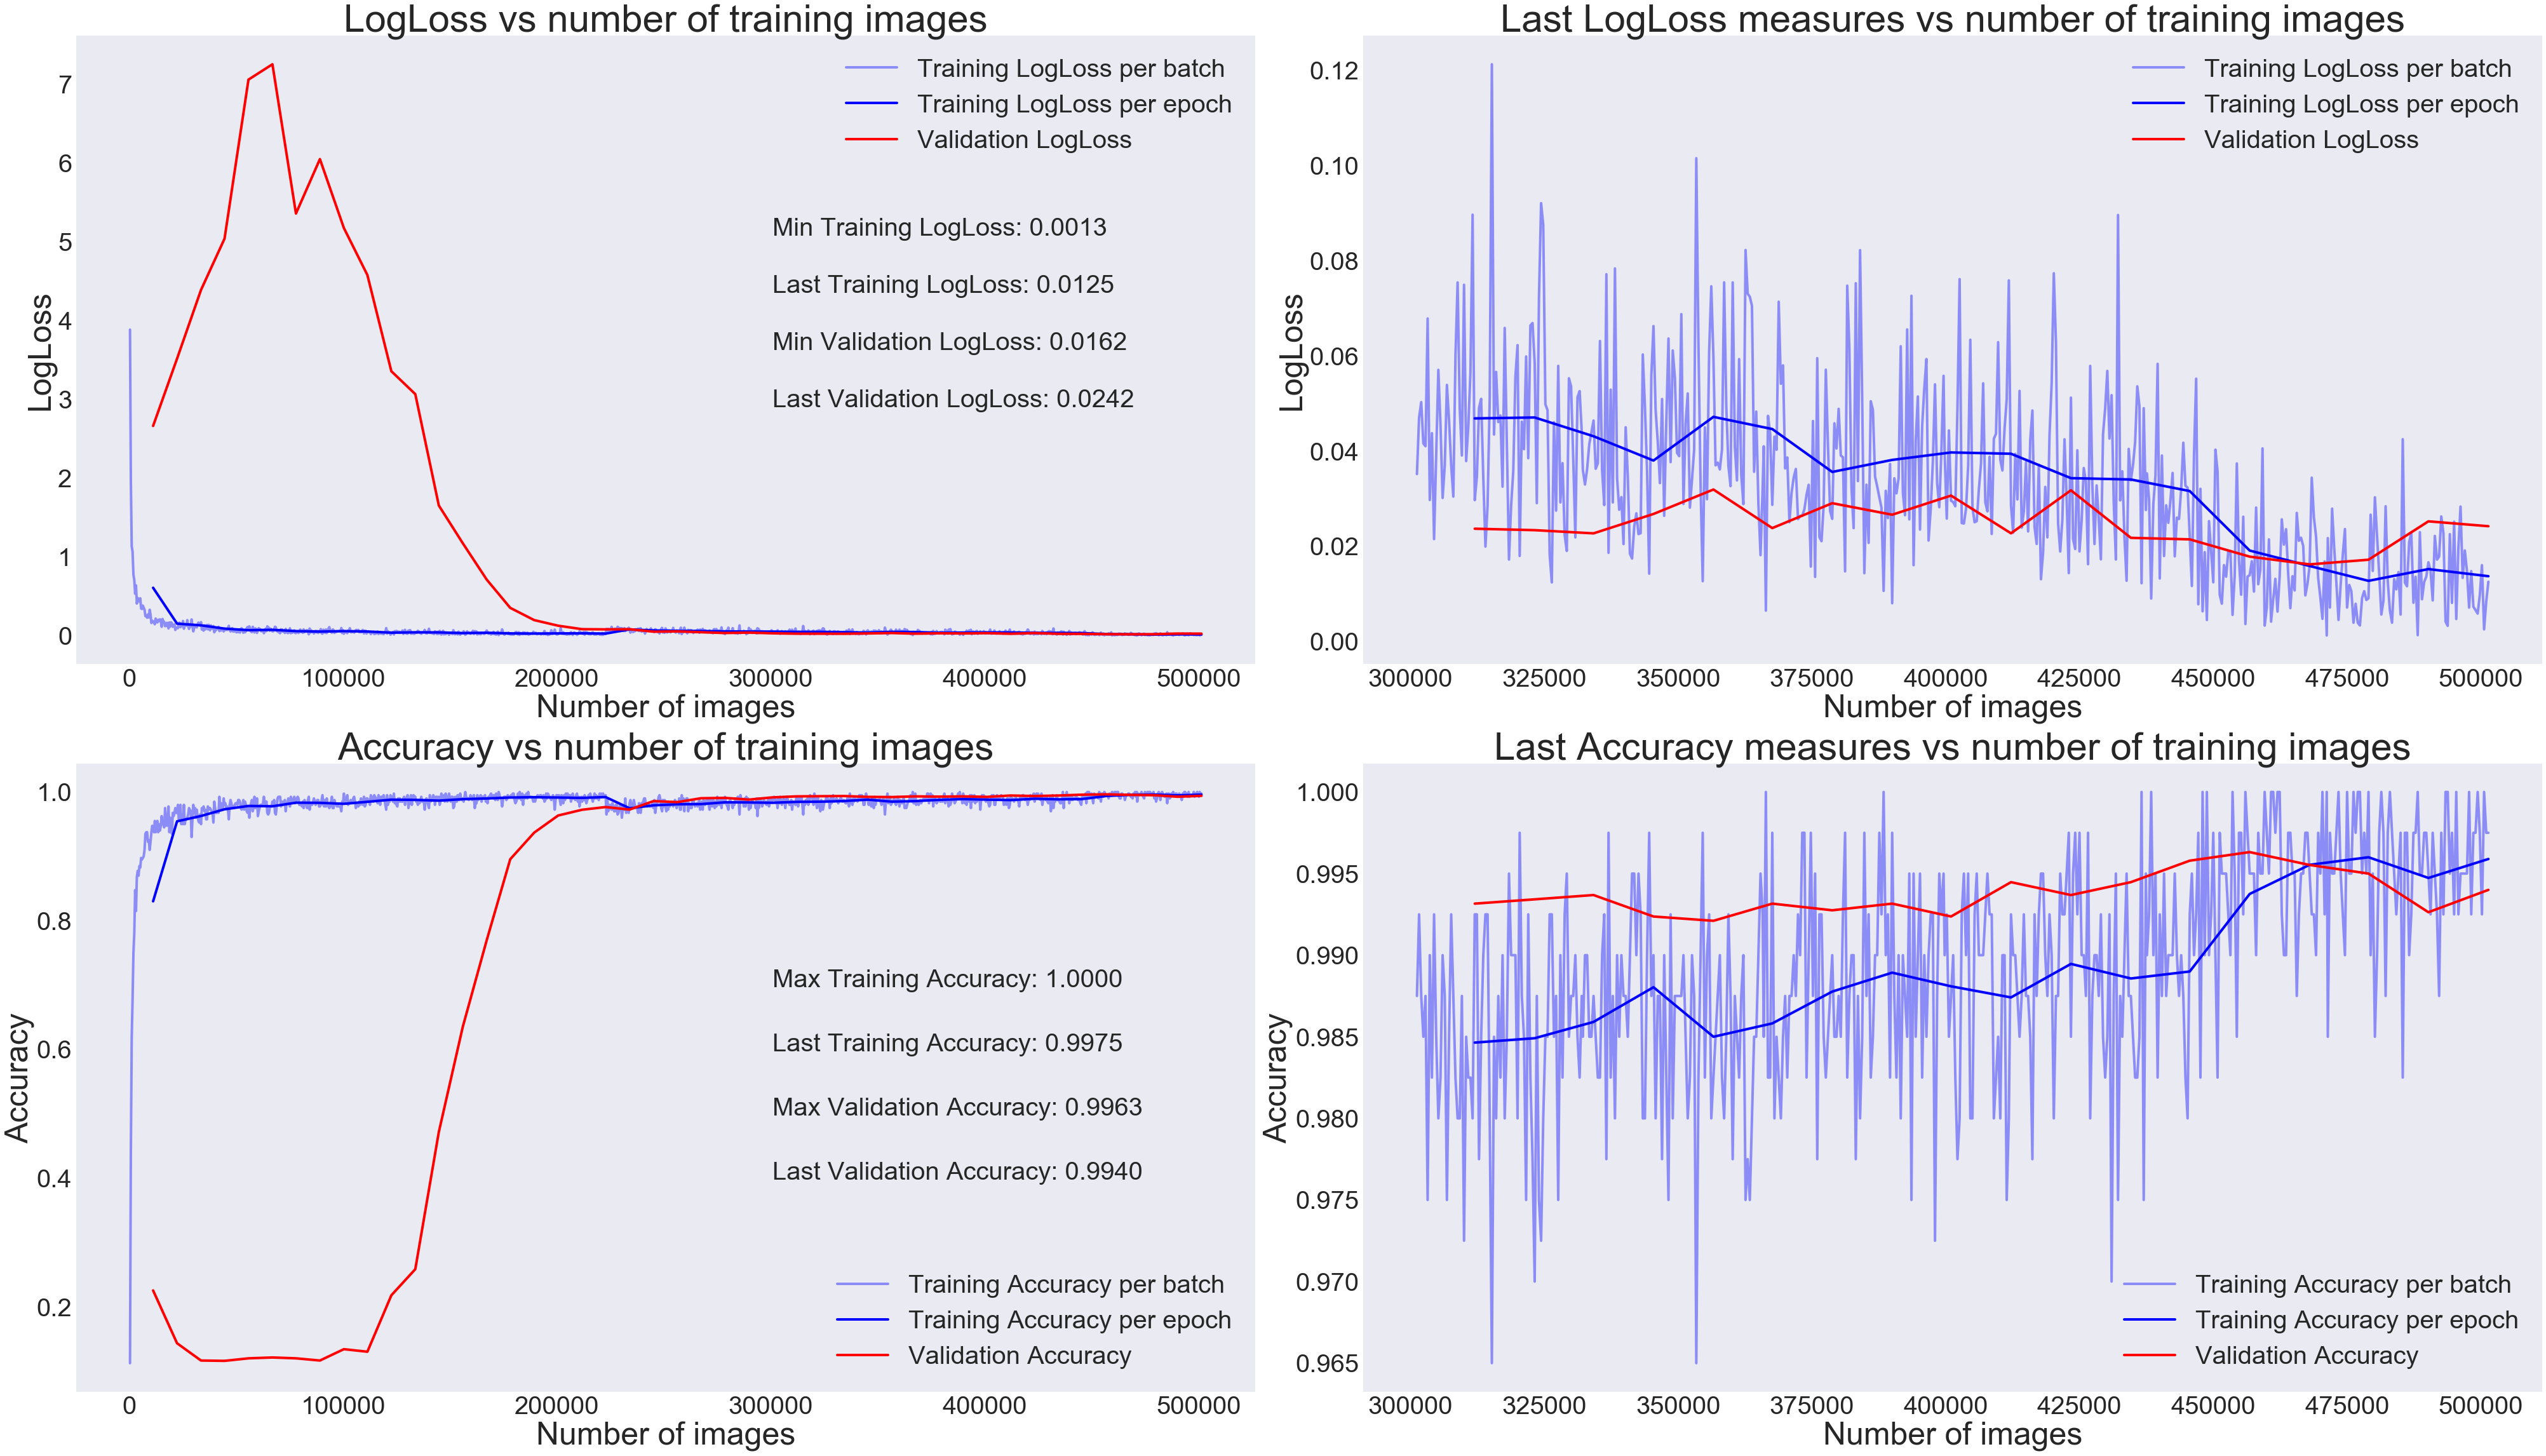

In [37]:
#Plot the loss curves for training and validation
plot_metrics(history, last_perc = 0.4)
plt.tight_layout()

We can see that the model is heavily overfitting up to around 400 batches and then quickly improves.

We can visualize kernels for the first convolution layer as well as it's output to see how our model "sees" the numbers.

In [38]:
def plot_layer(x, n_row, n_col , use_grid=False, start_cell=0):
    for j in range(min(len(x),n_row*n_col)):
        if (not use_grid):
            plt.subplot(n_row, n_col, start_cell+j+1)
        else:
            plt.subplot2grid((n_row, n_col), ((start_cell + j) // n_col - 1, (start_cell + j) % n_row), colspan=8) 
        plt.imshow(x[j], cmap=plt.get_cmap('gray'))
        plt.axis('off')
    #plt.tight_layout()
    return plt

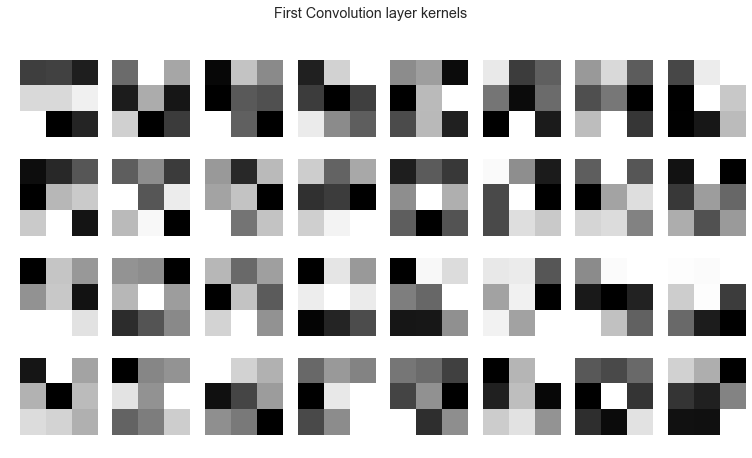

In [39]:
plt.figure(figsize=(13,7))
kernels = np.moveaxis(K.get_session().run(model.layers[0].kernel).reshape(3,3,1,32),3,0).reshape(32,3,3)
plot_layer(kernels,4,8)
plt.suptitle('First Convolution layer kernels')
plt.show()

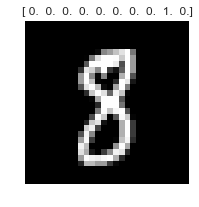

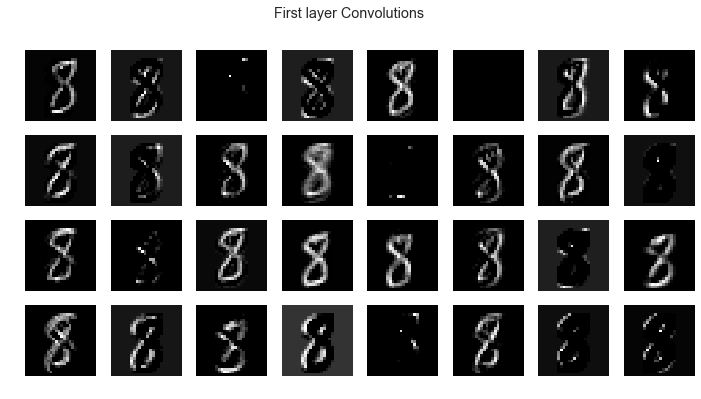

In [40]:
#get random training image
img_id = np.random.randint(len(X_train))
img = X_train[img_id]
#plt.subplots(5,8,figsize=(12,6))
#ax1 = plt.subplot2grid((5, 8), (0, 0), colspan=8)
plt.figure(figsize=(3,3))
plt.imshow(img.reshape(28,28), cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title(Y_train[img_id])
plt.show()

output = model.layers[0].output
input = model.layers[0].input

activations = K.get_session().run(output, feed_dict={input:img.astype(np.float32).reshape(1,28,28,1)})
activations = np.moveaxis(activations,3,0).reshape(32,26,26)
plt.figure(figsize=(12,6))
plot_layer(activations,4,8)
plt.suptitle('First layer Convolutions')
plt.show()

### <a name="ensembling"></a>4.3 Ensembling

In [41]:
def fit_model_and_save(model,ver=1,num=1,history=[],epochs_per_each_step=2, epochs_last_step=3,
                       steps=2,
                       start_lr=None, lr_decrease_after_steps=1):
    print("Training model: " + str(num))
    temp_history = History()
    model = fit_model(model, 
                      epochs_per_each_step=epochs_per_each_step,
                      epochs_last_step=epochs_last_step,
                      steps=steps,
                      use_train_batches = train_batches,
                      history_callback = history_callback,
                      model_save_callback=model_save_callback,
                      history=temp_history,
                      start_lr=start_lr,
                      lr_decrease_after_steps=lr_decrease_after_steps
                     )
    #load best model weights
    if (model_save_callback.best_model_weights != None):
        print("\nRetrieving best model weights with validation accuracy: " + str(model_save_callback.max_val_accuracy))
        model.set_weights(model_save_callback.best_model_weights)
    history.append(temp_history) #append metrics for each model to the list
    plot_metrics(temp_history, last_perc=0.4) #plot loss and accuracy curves for a finished model
    plt.show()
    print("Saving weights for model: " + str(num))
    model.save_weights(model_path + 'cnn-mnist-'+str(num)+'-v-' + ver+'.pkl')
    return model

We define a function load_model to be able to load previously trained weights and continue from that point.

In [49]:
def load_model(model,ver="2",num=1):
    model.load_weights(model_path + 'cnn-mnist-'+str(num)+'-v-' + str(ver)+'.pkl')
    return model

In [50]:
num_models = 6
dropouts = [[0,    0.1,  0.1,  0,    0.25, 0.5],
            [0.1,  0.1,  0.1,  0,    0.25, 0.5],
            [0.1,  0.1,  0.1,  0.1,  0.25, 0.5],
            [0.1,  0.1,  0.15, 0.1,  0.25, 0.5],
            [0.1,  0.15, 0.15, 0.1,  0.5,  0.5],
            [0.15, 0.15, 0.15, 0.15, 0.5,  0.5]
           ]
models = [cnn_model(x) for x in dropouts]

In [51]:
pickle_dump(dropouts,'cnn-dropouts-dump')

In [52]:
#models = [load_model(m,ver=1,num=i) for i,m in enumerate(models)]

In [53]:
histories = History()

In [ ]:
start_time = time.time()

Training model: 0
Starting with default learning rate.
Fitting step: 1
No data augmentation
Epoch 1/5
28/28 [==============================] - 25s - loss: 0.6150 - acc: 0.8317 - val_loss: 2.2256 - val_acc: 0.2047
Epoch 2/5
28/28 [==============================] - 22s - loss: 0.1822 - acc: 0.9464 - val_loss: 2.9423 - val_acc: 0.1179
Epoch 3/5
28/28 [==============================] - 22s - loss: 0.1151 - acc: 0.9634 - val_loss: 3.7705 - val_acc: 0.1158
Epoch 4/5
28/28 [==============================] - 22s - loss: 0.0879 - acc: 0.9736 - val_loss: 5.8794 - val_acc: 0.1184
Epoch 5/5
28/28 [==============================] - 22s - loss: 0.0749 - acc: 0.9766 - val_loss: 5.2120 - val_acc: 0.1221
Fitting step: 2
Setting learning rate to: 0.1
No data augmentation
Epoch 1/5
28/28 [==============================] - 22s - loss: 0.0689 - acc: 0.9787 - val_loss: 5.6868 - val_acc: 0.1174
Epoch 2/5
28/28 [==============================] - 22s - loss: 0.0629 - acc: 0.9800 - val_loss: 5.4376 - val_acc: 0

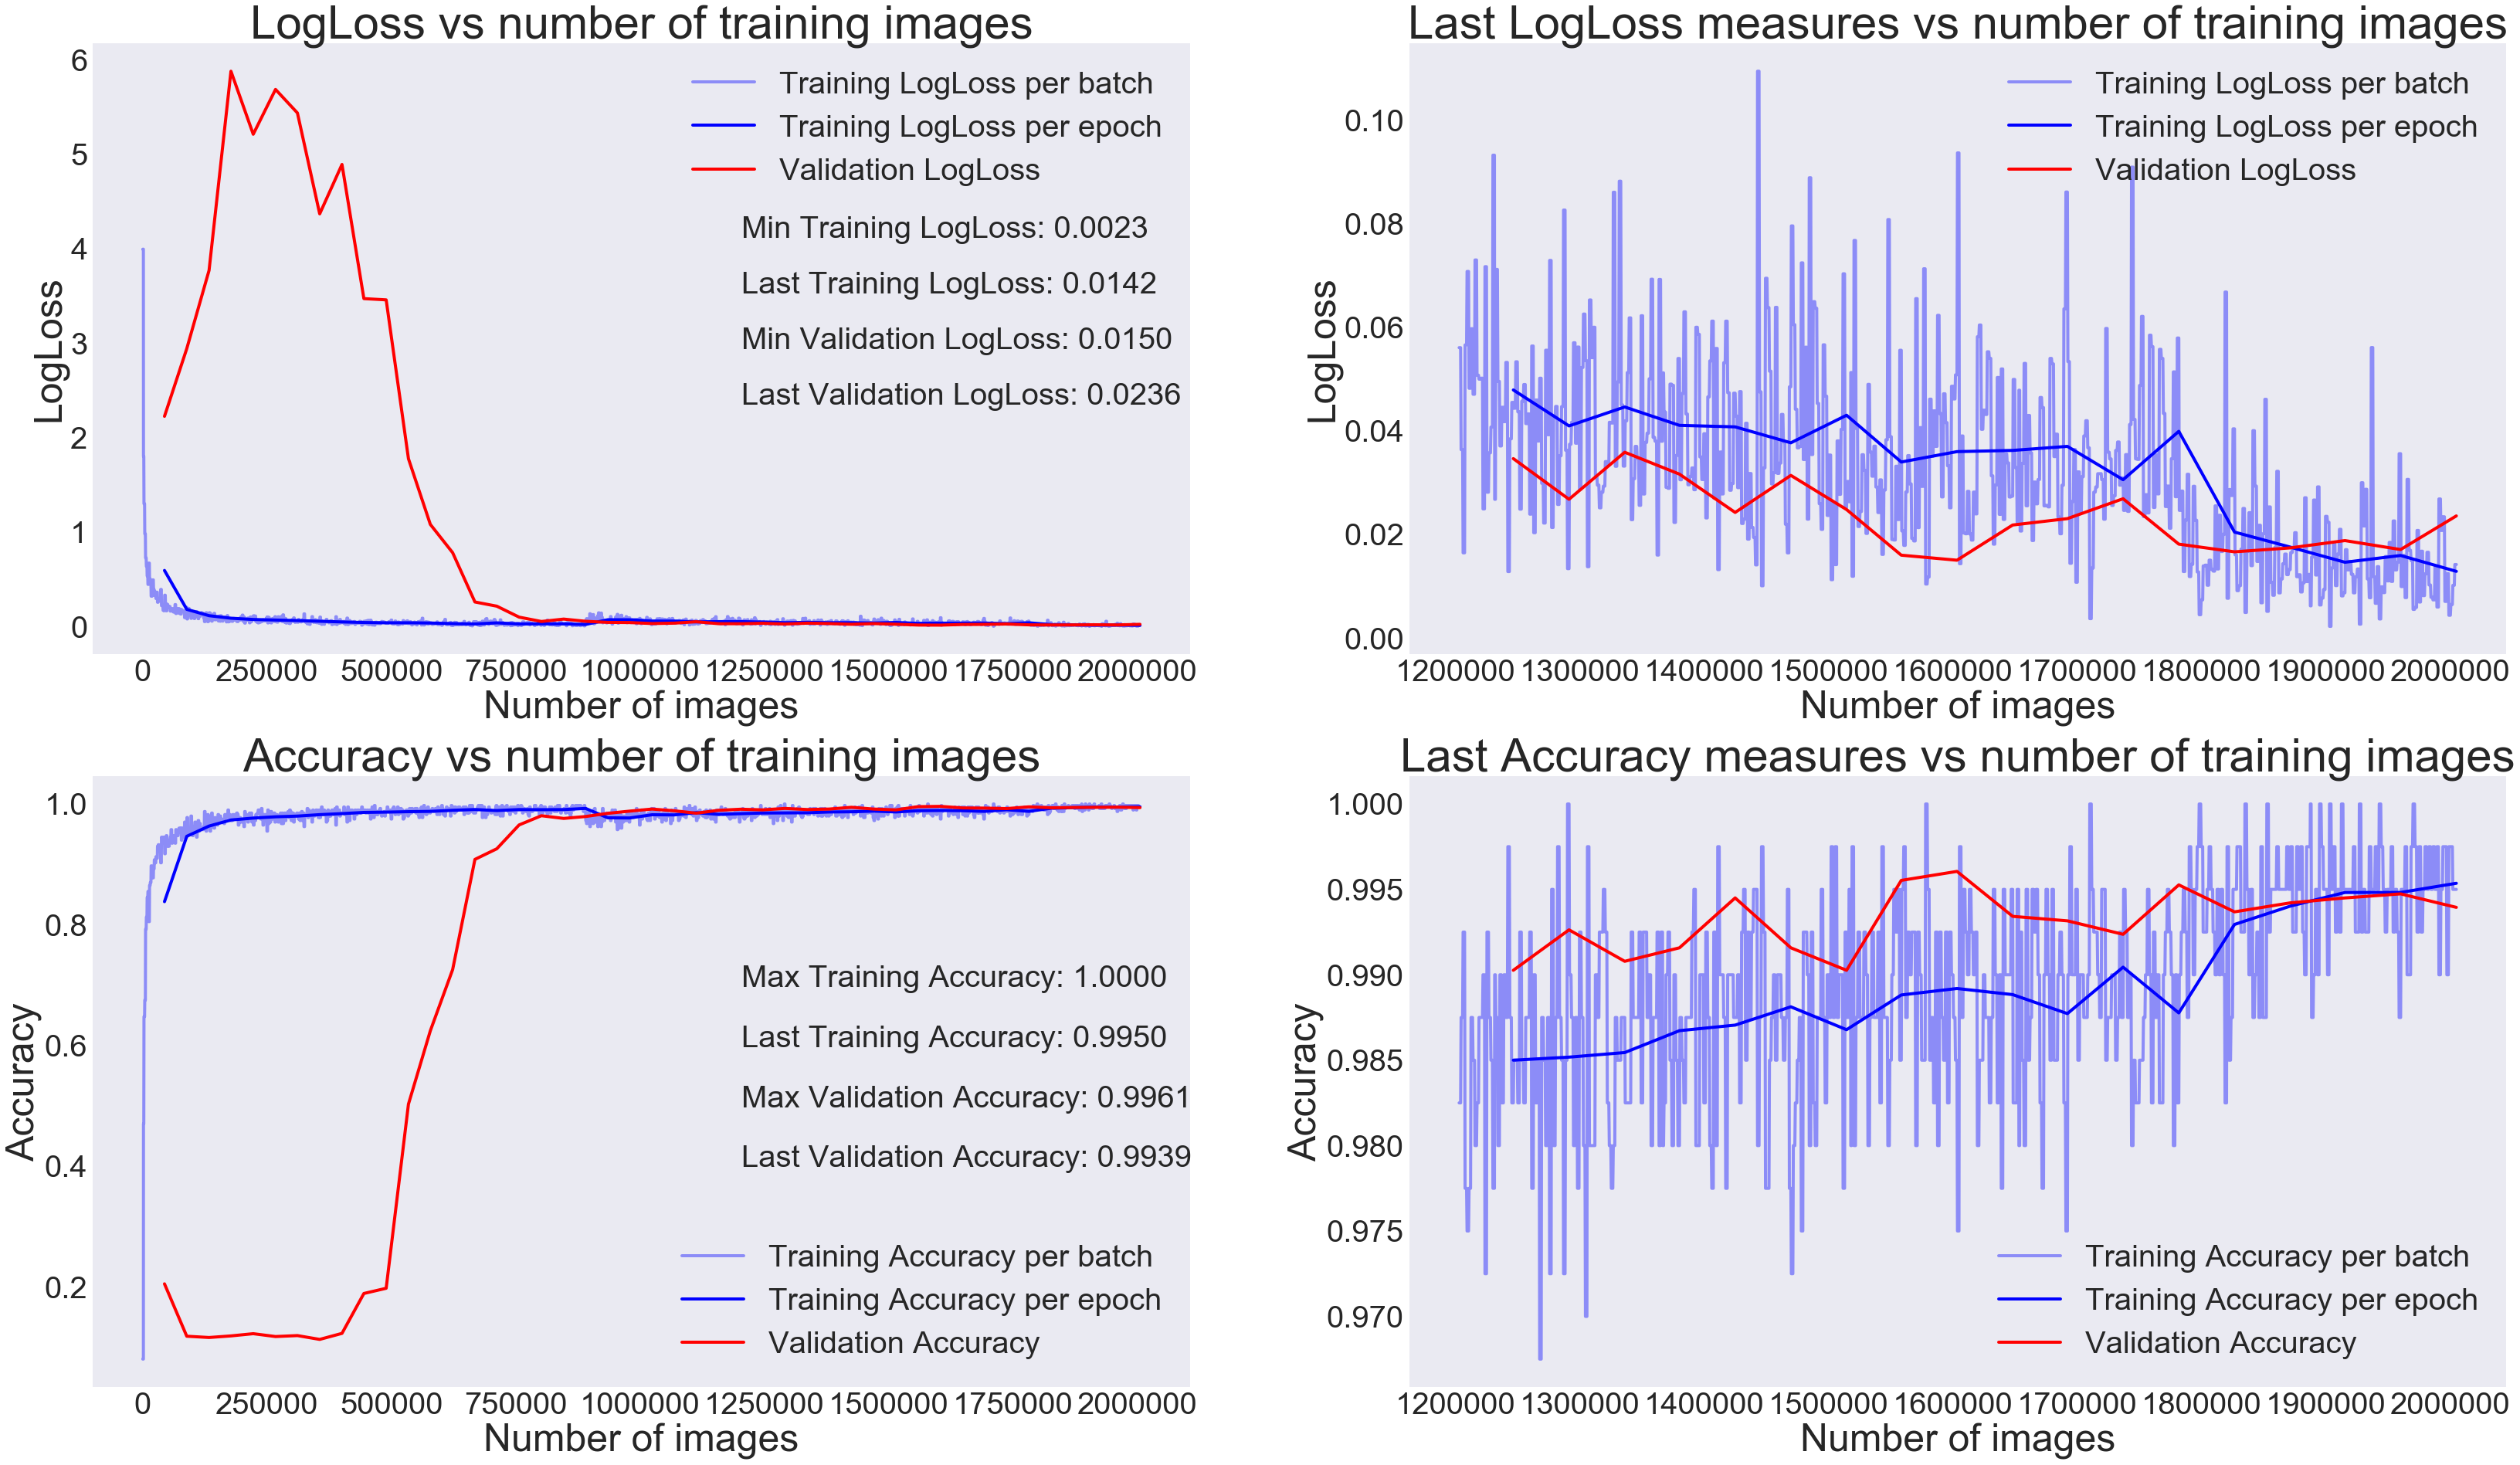

Saving weights for model: 0
Training model: 1
Starting with default learning rate.
Fitting step: 1
No data augmentation
Epoch 1/5
28/28 [==============================] - 24s - loss: 0.6036 - acc: 0.8309 - val_loss: 2.7083 - val_acc: 0.1913
Epoch 2/5
28/28 [==============================] - 23s - loss: 0.1813 - acc: 0.9454 - val_loss: 3.9279 - val_acc: 0.2005
Epoch 3/5
28/28 [==============================] - 23s - loss: 0.1228 - acc: 0.9641 - val_loss: 4.8272 - val_acc: 0.1200
Epoch 4/5
28/28 [==============================] - 23s - loss: 0.0908 - acc: 0.9708 - val_loss: 5.0254 - val_acc: 0.1187
Epoch 5/5
28/28 [==============================] - 23s - loss: 0.0827 - acc: 0.9746 - val_loss: 6.5390 - val_acc: 0.1132
Fitting step: 2
Setting learning rate to: 0.1
No data augmentation
Epoch 1/5
28/28 [==============================] - 23s - loss: 0.0643 - acc: 0.9801 - val_loss: 6.8162 - val_acc: 0.1218
Epoch 2/5
28/28 [==============================] - 22s - loss: 0.0666 - acc: 0.9795 - v

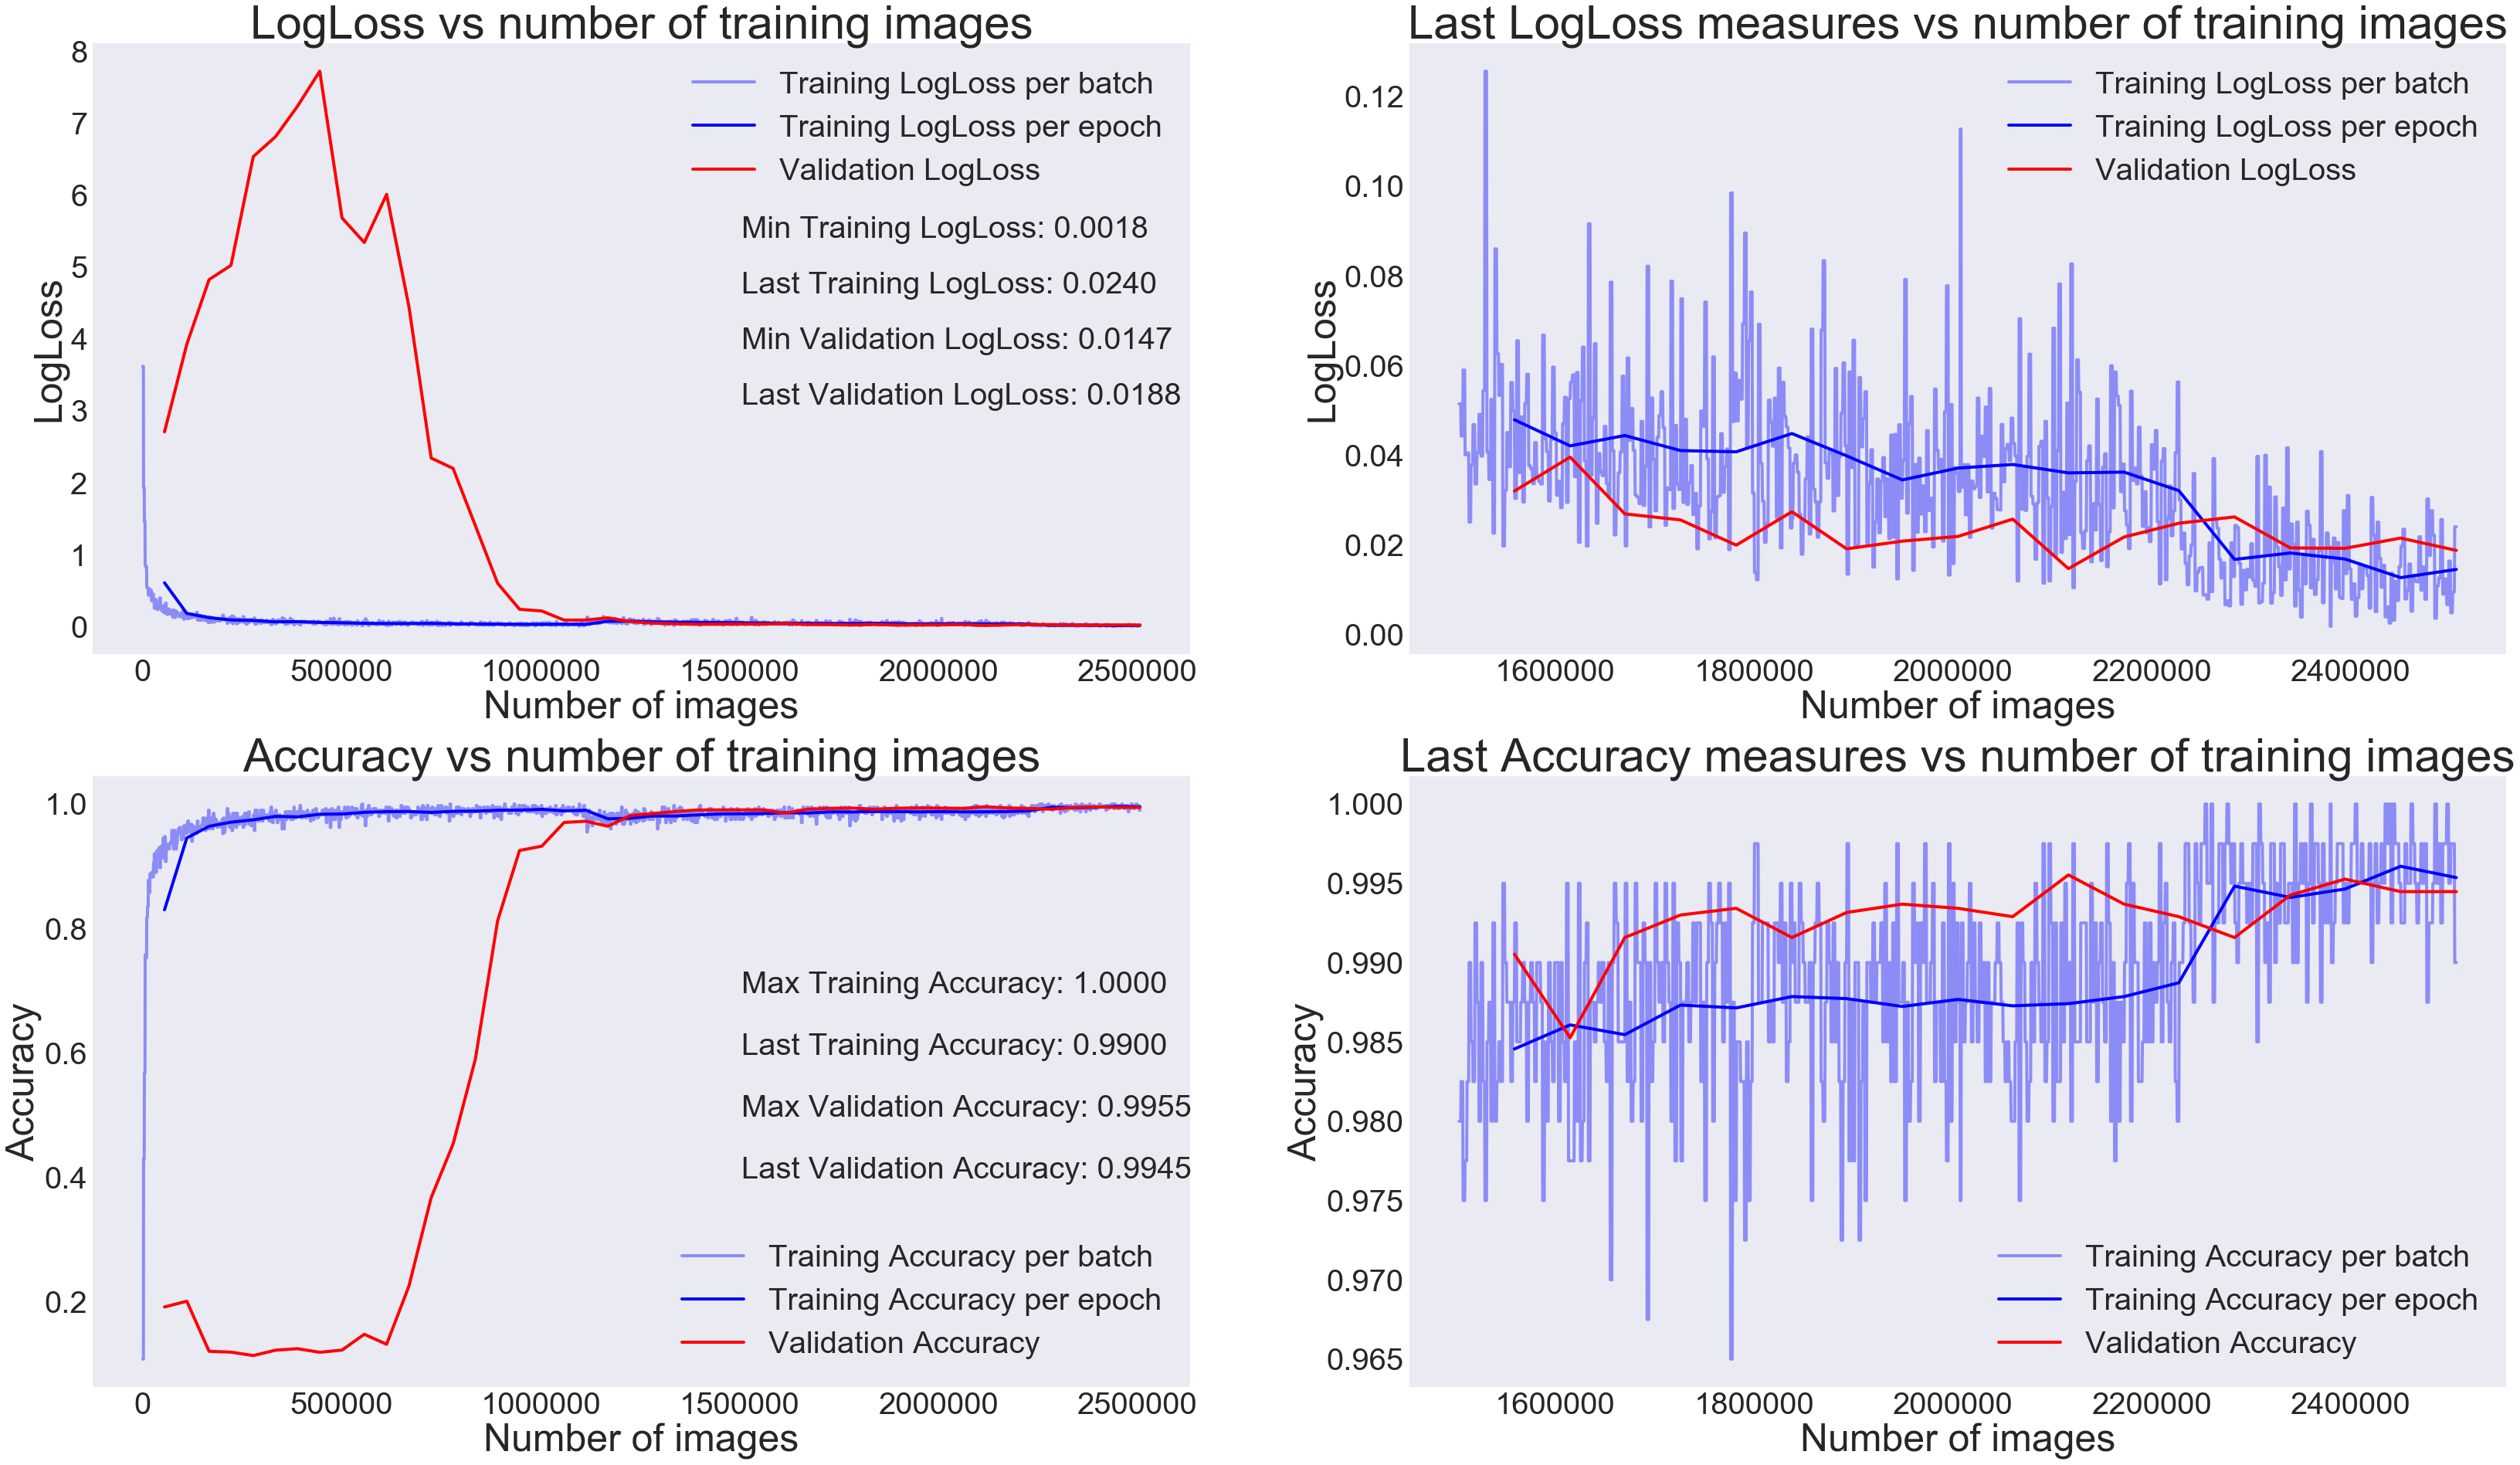

Saving weights for model: 1
Training model: 2
Starting with default learning rate.
Fitting step: 1
No data augmentation
Epoch 1/5
28/28 [==============================] - 30s - loss: 0.7214 - acc: 0.7959 - val_loss: 2.0458 - val_acc: 0.4289
Epoch 2/5
28/28 [==============================] - 23s - loss: 0.2075 - acc: 0.9383 - val_loss: 1.8890 - val_acc: 0.5142
Epoch 3/5
28/28 [==============================] - 23s - loss: 0.1370 - acc: 0.9571 - val_loss: 1.8588 - val_acc: 0.5218
Epoch 4/5
28/28 [==============================] - 23s - loss: 0.1143 - acc: 0.9645 - val_loss: 1.6809 - val_acc: 0.4747
Epoch 5/5
28/28 [==============================] - 23s - loss: 0.0899 - acc: 0.9721 - val_loss: 1.9273 - val_acc: 0.3311
Fitting step: 2
Setting learning rate to: 0.1
No data augmentation
Epoch 1/5
28/28 [==============================] - 24s - loss: 0.0741 - acc: 0.9765 - val_loss: 1.6206 - val_acc: 0.3071
Epoch 2/5
28/28 [==============================] - 24s - loss: 0.0793 - acc: 0.9771 - v

In [ ]:
models = [fit_model_and_save(m,ver=version,num=i,history=histories,
                             epochs_per_each_step=5,
                             epochs_last_step=5,
                             steps=[4,4],
                             lr_decrease_after_steps=2
                            ) for i,m in enumerate(models)]

In [ ]:
elapsed_time = time.time() - start_time
print("Elapsed model ensemble training time: " + str(elapsed_time//60) + " minutes " + str(elapsed_time % 60) + " seconds")

In [ ]:
pickle_dump(histories,'cnn-ensemble-train-histories-dump')

We can add our single trained model to the ensemble.

In [ ]:
models_all = models
models_all.append(model)

In [ ]:
evals = np.array([m.evaluate(X_val, Y_val, batch_size=batch_size) for m in models_all])

In [ ]:
print("Mean prediction accuracy of the ensembled models: " + str(evals.mean(axis=0)[1]))

In [ ]:
all_preds = np.stack([m.predict(X_val, batch_size=batch_size,verbose=1) for m in models_all])
all_preds.shape
avg_preds = all_preds.mean(axis=0)
acc = categorical_accuracy(tf.convert_to_tensor(Y_val), tf.convert_to_tensor(avg_preds)).eval(session=K.get_session())
print("Accuracy of the ensemble of models: " + str(acc.sum()/Y_val.shape[0]))

### <a name="confusion-matrix"></a>4.4 Confusion matrix and classification report

In [ ]:
#val_preds = model.predict(X_val, batch_size=100,verbose=1)
#use prediction from ensembling
val_preds = avg_preds

Let's first define a function that will plot our confusion matrix.

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
conf_matrix = confusion_matrix(np.argmax(Y_val,axis=1),np.argmax(val_preds,axis=1))
plot_confusion_matrix(conf_matrix, classes=range(10))

Now let's look at f1-score precision and recall to see how our model is performing on each digit.

In [ ]:
print(classification_report(np.argmax(Y_val,axis=1),np.argmax(val_preds,axis=1)))

Now let's look at some predictions and their true labels in the validation set

In [ ]:
n_view = 6
ids = np.random.choice(range(0,len(X_val)),size=n_view,replace=False)
#X_vis = X_data_np[ids]
#Y_vis = Y_data.iloc[ids]
#X_vis = X_vis.reshape(-1,28,28)

plt.subplots(2,3)
for i,id in enumerate(ids):
    plt.subplot(2,3, i+1)
    plt.imshow(X_val[id].reshape(28,28),cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title("Predicted: " + str(np.argmax(val_preds[id])) +
              "\n probability: " + str(val_preds[id][np.argmax(val_preds[id])]) +
              "\n True label: " + str(np.argmax(Y_val[id])))
    plt.tight_layout()
plt.show() 

To do: Investigate the errors.

In [ ]:
errors = (np.argmax(val_preds,axis=1) != np.argmax(Y_val,axis=1))
error_probs = val_preds[errors]
error_probs = [er[np.argmax(er)]  for i,er in enumerate(error_probs)]
error_labels = np.argmax(val_preds,axis=1)[errors]
error_imgs = X_val[errors]
error_true_label = np.argmax(Y_val[errors],axis=1)
errors_df = pd.DataFrame({'label':error_labels,
                          'prob':error_probs,
                          'img_id':range(len(error_imgs)),
                          'True label':error_true_label})
errors_df.sort_values('prob',inplace=True,ascending=False)
errors_df.reset_index(inplace=True)
print("Number of errors in the validation set: " + str(sum(errors)))
errors_df.head()

In [ ]:
#n_view = 7
n_rows = 5
n_cols = 5
n_view = min(len(errors), n_rows * n_cols)

plt.subplots(n_rows,n_cols,figsize=(16,24))
for i,row in errors_df.iloc[:n_view,:].iterrows():
    plt.subplot(n_rows,n_cols, i+1)
    plt.imshow(error_imgs[row['img_id'].astype(np.int32)].reshape(28,28),cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.title("Predicted: " + str(row['label']) +
              "\n probability: " + str(row['prob']) +
              "\n True label: " + str(row['True label']))
    plt.tight_layout()
plt.show() 

It looks like some of the digits are cut. Perhaps we could add more translation to data augmentation to use more obstructed digits in traing.